# Qwen2 VL model finetuning with Unsloth

## Imports

In [11]:
import torch
import os
from tqdm import tqdm

from datasets import load_dataset
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

## Constants

In [13]:
TRAIN_SET = "Train"
TEST_SET = "Test"
VAL_SET = "Valid"

LORA_RANK = 16
LORA_ALPHA = 16
LORA_DROPOUT = 0

os.environ["WANDB_PROJECT"] = "qwen2-vl-finetuning-logs"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

## Loading the model

In [37]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2024.12.4: Fast Qwen2_Vl vision patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.151 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [38]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,  # False if not finetuning vision layers
    finetune_language_layers=True,  # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,  # False if not finetuning MLP layers
    r=LORA_RANK,  # The larger, the higher the accuracy, but might overfit
    lora_alpha=LORA_ALPHA,  # Recommended alpha == r at least
    lora_dropout=LORA_DROPOUT,
    bias="none",
    random_state=3407,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## Loading the dataset

In [5]:
train_dataset = load_dataset("adishourya/MEDPIX-ShortQA", split=TRAIN_SET)
test_dataset = load_dataset("adishourya/MEDPIX-ShortQA", split=TEST_SET)
val_dataset = load_dataset("adishourya/MEDPIX-ShortQA", split=VAL_SET)

### Dataset preview

Question: What might the diagnosis be?
Answer: The possible diagnosis includes Epidermoid Tumor
Arachnoid Cyst.


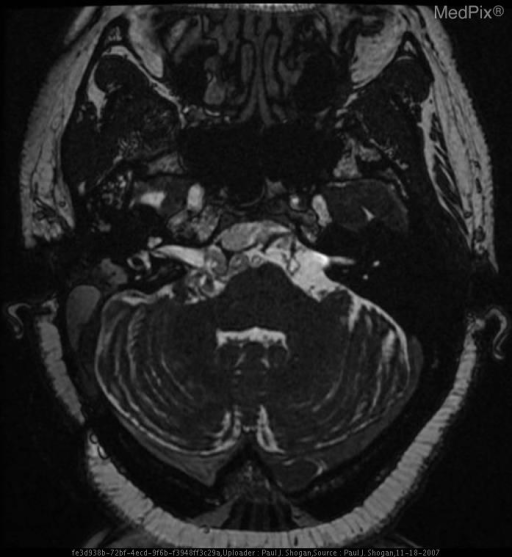

In [39]:
print(f"Question: {train_dataset[0]['question']}\nAnswer: {train_dataset[0]['answer']}")
train_dataset[0]["image_id"]

## Define chat template and convert dataset

In [7]:
def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": sample["question"]},
                {"type": "image", "image": sample["image_id"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["answer"]}]},
    ]
    return {"messages": conversation}

In [8]:
train_set = [convert_to_conversation(sample) for sample in train_dataset]
test_set = [convert_to_conversation(sample) for sample in test_dataset]
val_set = [convert_to_conversation(sample) for sample in val_dataset]

In [9]:
train_set[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'What might the diagnosis be?'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x557>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The possible diagnosis includes Epidermoid Tumor\nArachnoid Cyst.'}]}]}

## Inference on few samples

In [40]:
def run_test_set(dataset, batch_size=8):
    FastVisionModel.for_inference(model)
    ground_truths, responses = [], []

    for sample in tqdm(
        dataset,
        desc="Running inference on test set",
        bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
    ):
        image = sample["messages"][0]["content"][1]["image"]
        question = sample["messages"][0]["content"][0]["text"]
        answer = sample["messages"][1]["content"][0]["text"]

        messages = [
            {
                "role": "user",
                "content": [{"type": "image"}, {"type": "text", "text": question}],
            }
        ]
        input_text = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
        )
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt",
        ).to("cuda")
        with torch.no_grad():
            generated_ids = model.generate(
                **inputs, max_new_tokens=128, use_cache=True, temperature=0.5, min_p=0.1
            )
        generated_ids_trimmed = [
            out_ids[len(in_ids) :]
            for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        response = tokenizer.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )[0]
        responses.append(response)
        ground_truths.append(answer)
        torch.cuda.empty_cache()
    return ground_truths, responses

In [ ]:
ground_truths, responses = run_test_set(test_set, batch_size=8)

Running inference on test set:  64%|██████▎   | 624/980 [1:03:12<31:05,  5.24s/it]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## Evaluating results on test set

In [ ]:
from bert_score import score

P, R, F1 = score(responses, ground_truths, lang="en", verbose=True, nthreads=10)

print(
    f"""
Precision: {P}
Recall: {R}
F1 Score: {F1}
"""
)

## Training the model

In [26]:
FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=train_set,
    eval_dataset=val_set,
    args=SFTConfig(
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=8,
        save_total_limit=1,
        warmup_steps=5,
        # max_steps = 30,
        num_train_epochs=2,  # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=100,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        save_strategy="steps",
        save_steps=100,
        report_to=["wandb"],
        # For vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [16]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100 80GB PCIe. Max memory = 79.151 GB.
6.154 GB of memory reserved.


In [27]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 11,574 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 8
\        /    Total batch size = 32 | Total steps = 722
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
100,1.012700
200,1.039700
300,0.987200
400,0.890200
500,0.779800
600,0.741300
700,0.744700


wandb: Adding directory to artifact (./outputs/checkpoint-722)... Done. 5.8s


In [28]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

8132.8665 seconds used for training.
135.55 minutes used for training.
Peak reserved memory = 36.111 GB.
Peak reserved memory for training = 29.957 GB.
Peak reserved memory % of max memory = 45.623 %.
Peak reserved memory for training % of max memory = 37.848 %.


## Test model on test set

In [31]:
def run_test_set(dataset):
    FastVisionModel.for_inference(model)
    ground_truths, responses = [], []

    for sample in tqdm(dataset, desc="Running inference on test set",bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",):
        image = sample["messages"][0]["content"][1]["image"]
        question = sample["messages"][0]["content"][0]["text"]
        answer = sample["messages"][1]["content"][0]["text"]

        messages = [
            {
                "role": "user",
                "content": [{"type": "image"}, {"type": "text", "text": question}],
            }
        ]
        input_text = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
        )
        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt",
        ).to("cuda")

        generated_ids = model.generate(
            **inputs, max_new_tokens=128, use_cache=True, temperature=0.5, min_p=0.1
        )
        generated_ids_trimmed = [
            out_ids[len(in_ids) :]
            for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        response = tokenizer.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )[0]
        responses.append(response)
        ground_truths.append(answer)
    return ground_truths, responses

In [32]:
ground_truths, responses = run_test_set(test_set)

Running inference on test set:   0%|          | 0/980 [00:00<?, ?it/s]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Running inference on test set: 100%|██████████| 980/980 [40:35<00:00,  2.49s/it]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


In [34]:
from bert_score import score

P, R, F1 = score(responses, ground_truths, lang="en", verbose=True, nthreads=10)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  7.16it/s]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 124.39it/s]

done in 3.77 seconds, 259.93 sentences/sec


In [35]:
print(
    f"""
Precision: {P.mean().cpu().numpy()}
Recall: {R.mean().cpu().numpy()}
F1 Score: {F1.mean().cpu().numpy()}
"""
)


Precision: 0.873792290687561
Recall: 0.8723830580711365
F1 Score: 0.8726606369018555

